In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
from scipy.spatial import distance_matrix
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../../scripts")
from TrackReconstruction_functions import *

pd.options.mode.chained_assignment = None  # Disable the warning

pressure=5
# diffusion="0.0percent"
# diffusion="nodiff"
diffusion="deconv"
file_id = "1"
# diffusion = "next1t"

diff_name = f"_{diffusion}"
if diff_name == "_nodiff":
    diff_name=""

mode = "MC"
mode = "data"

recostage = "beersheeba"

if recostage == "beersheeba":
    load_string = "/DECO/Events"

if mode == "MC":
    hits_true = pd.read_hdf(f"../../data/ATPC_0nubb/ATPC_0nubb_{pressure}bar_EFilt_smear_{file_id}.h5", "MC/hits")

# hits      = pd.read_hdf(f"../../data/NEXT100/beersheba_ldc1_1013.h5", load_string)
hits      = pd.read_hdf(f"data/beersheba_ldc1_1013_beershireba.h5", load_string)


hits = hits[["event", "X", "Y", "Z", "E"]]
hits = hits.rename(columns={"event":"event_id","X": "x", "Y": "y", "Z": "z", "E":"energy"})

display(hits)

event_list = hits.event_id.unique()

print(hits.event_id.unique())

,event_id,x,y,z,energy
0,741469,-413.625,-7.925,-4.766094,0.000016
1,741469,-413.625,-2.925,-4.766094,0.000261
2,741469,-413.625,-2.925,-0.766094,0.000021
3,741469,-413.625,2.075,-4.766094,0.000302
4,741469,-413.625,2.075,-0.766094,0.000074
...,...,...,...,...,...
1314,768972,17.375,389.075,842.797438,0.000049
1315,768972,17.375,394.075,838.797438,0.000511
1316,768972,22.375,384.075,838.797438,0.000118
1317,768972,22.375,389.075,838.797438,0.000756


[741469 741574 741686 741777 741826 742169 742253 742512 742575 742708
 742827 742841 742883 742904 742974 743261 743380 743422 743674 743744
 743765 743912 743954 744073 744353 744542 744710 744857 744878 744920
 745025 745354 745368 745410 745417 745557 745851 746187 746320 746334
 746369 746523 746698 746705 746712 746747 747006 747153 747209 747293
 747993 748063 748231 748651 748812 749022 749260 749316 749659 749967
 750079 750261 750296 750681 751003 751066 751192 751577 751829 751885
 751913 752074 752165 752396 752536 752641 752949 752970 753201 753348
 753362 753733 753768 753789 753922 753992 754244 754279 754377 754643
 754888 754937 754944 755000 755028 755224 755259 755371 755392 755399
 755721 755770 755840 756288 756316 756428 756708 756757 756771 756820
 756848 757058 757324 757513 757527 757618 757632 757702 757849 757891
 757898 757954 757996 758150 758521 758738 758878 758962 759396 759522
 759690 759718 759739 759760 760082 760131 760173 760523 760607 760768
 76081

In [85]:
# eid=9844
eid=event_list[21]

data = hits[hits.event_id ==eid]
print(data.energy.sum())

if mode == "MC":
    data_true = hits_true[hits_true.event_id ==eid]
    display(data_true)
    print(data_true.energy.sum())




1.3549470218267974


In [86]:
hits.describe()

,event_id,x,y,z,energy
count,302317.000000,302317.000000,302317.000000,302317.000000,3.023170e+05
mean,755340.359298,111.057661,105.358884,703.458899,1.020142e-03
std,8068.550587,196.914600,209.911380,498.095737,1.209765e-03
min,741469.000000,-469.625000,-472.925000,-1335.214462,3.415744e-07
25%,748063.000000,-6.625000,-28.925000,473.607000,2.131552e-04
50%,755371.000000,149.375000,156.075000,699.320250,6.963862e-04
75%,762238.000000,265.375000,270.075000,944.466875,1.461518e-03
max,768972.000000,472.375000,474.075000,2656.525187,4.963364e-02


In [87]:

Diff_smear, energy_threshold, diff_scale_factor, radius_sf, group_sf, Tortuosity_dist, voxel_size, det_size  = InitializeParams(pressure, diffusion)
# voxel_sf=1.1
print("Diffussion smear is: ",        Diff_smear,            "mm/sqrt(cm)")
print("Energy threshold is: ",        1000*energy_threshold, "keV")
print("diffision scale factor is: ",  diff_scale_factor)
print("Radius scale factor is: ",     radius_sf)
print("Hit grouping factor is: ",     group_sf)
print("Tortuosity distance scale is:", Tortuosity_dist)
print("The voxel size is:",           voxel_size)
print("The det_size is", det_size)

mean_sigma = diff_scale_factor*Diff_smear*np.sqrt(0.1*data.z.mean())


# The expected diffusion is less than vox size so replace
if (mean_sigma < 1.5*voxel_size):
    mean_sigma = 1.5*voxel_size


if (diffusion == "next1t"):
    mean_sigma=6
elif (diffusion == "nodiff"):
    mean_sigma=10/np.sqrt(pressure)
elif (diffusion == "deconv"):
    mean_sigma = 25

print("Mean sigma", mean_sigma)

# Create the bins ---- 
xbw  = mean_sigma
xmin = -500
xmax = 500

ybw  = mean_sigma
ymin = -500
ymax = 500

# This shifts the z pos of the events so 0 is at anode
# can set this to zero
# z_shift = det_size
z_shift = 0

zbw=mean_sigma
zmin=-1500
zmax=3000

# bins for x, y, z
xbins = np.arange(xmin, xmax+xbw, xbw)
ybins = np.arange(ymin, ymax+ybw, ybw)
zbins = np.arange(zmin, zmax+zbw, zbw)

# center bins for x, y, z
xbin_c = xbins[:-1] + xbw / 2
ybin_c = ybins[:-1] + ybw / 2
zbin_c = zbins[:-1] + zbw / 2


Diffussion smear is:  0.1 mm/sqrt(cm)
Energy threshold is:  0.0 keV
diffision scale factor is:  7
Radius scale factor is:  10
Hit grouping factor is:  20
Tortuosity distance scale is: 15
The voxel size is: 5
The det_size is 1807.7267582900142
Mean sigma 25


/var/folders/cf/0fb79lcx5z9by5185swm__x00000gr/T/ipykernel_93221/2150901379.py:12: RuntimeWarning: invalid value encountered in sqrt
  mean_sigma = diff_scale_factor*Diff_smear*np.sqrt(0.1*data.z.mean())


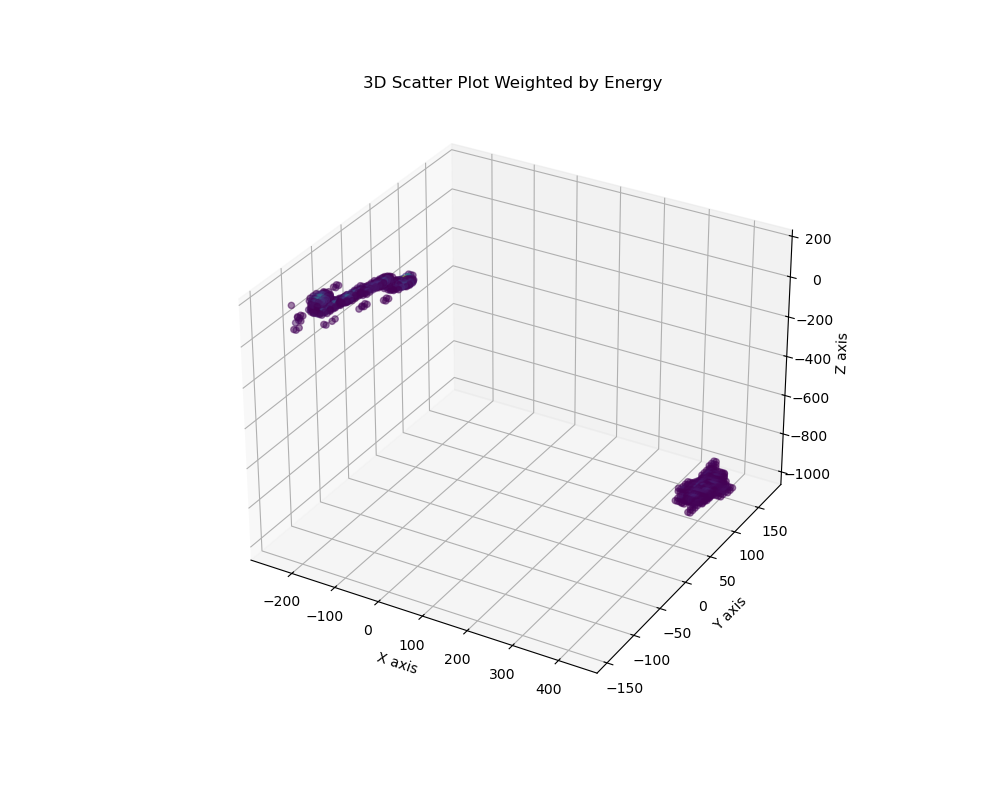

In [88]:
%matplotlib widget 

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Normalize the energy values for the colors
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(data.energy.min(), data.energy.max())
colors = cmap(norm(data.energy))


# Plot the scatter plot
scatter = ax.scatter(data.x, data.y, data.z, c=colors, marker='o', alpha=0.5)
# ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o', c="DarkOrange")

# ax.scatter(data_true['x'], data_true['y'], data_true['z']+3000, marker='o', c="DarkRed")

# Add color bar to indicate energy values
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
mappable.set_array(data.energy)
# cbar = plt.colorbar(mappable)
# cbar.set_label('Energy')

# Set labels and title
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('3D Scatter Plot Weighted by Energy')

plt.show()

In [89]:
print(data.energy.sum())

# If there are overlapping voxels, merge them. Otherwise the energy gets messed up
data = (data.groupby(["event_id", "x", "y", "z"], as_index=False)["energy"].sum())

# display(data)
data = data[['event_id','x', 'y', 'z',"energy"]]

# then sort it based on the x,y,z
data = data.sort_values(by=['x', "y", "z"]).reset_index(drop=True)

print(data.energy.sum())
display(data)

1.3549470218267974
1.3549470218267974


,event_id,x,y,z,energy
0,743912,-246.625,-119.925,123.826094,0.000043
1,743912,-231.625,-99.925,123.826094,0.000094
2,743912,-231.625,-94.925,123.826094,0.000267
3,743912,-231.625,-89.925,123.826094,0.000048
4,743912,-226.625,-104.925,123.826094,0.000137
...,...,...,...,...,...
1516,743912,428.375,135.075,-972.173906,0.000371
1517,743912,428.375,140.075,-972.173906,0.000178
1518,743912,433.375,130.075,-972.173906,0.000046
1519,743912,433.375,135.075,-972.173906,0.000077


In [ ]:

def GroupHits(df, threshold):

    # Convert to NumPy array for clustering
    coords = df[["x", "y", "z"]].to_numpy()

    # Apply DBSCAN
    db = DBSCAN(eps=threshold, min_samples=1).fit(coords)

    # Add group labels to the original DataFrame
    df["group_id"] = db.labels_

    if (len(df.group_id.unique()) > 15):
        print("Running grouping again new mean sigma is:", threshold*2)
        df = GroupHits(df, threshold*2)

    return df

# display(data)

print("Mean z:", data.z.mean(), " diffusion = ", mean_sigma)
print("Mean Sigma: ", mean_sigma)

# Apply grouping
data_copy = data.copy()

df_merged = CutandRedistibuteEnergy(data_copy, energy_threshold)
print(len(df_merged))

mean_sigma_group = group_sf*Diff_smear*np.sqrt(0.1*data.z.mean())

if (mean_sigma_group < voxel_size/2.0):
    mean_sigma_group = voxel_size/2.0

if diffusion == "next1t":
    mean_sigma_group = 10
elif (diffusion == "deconv"):
    mean_sigma_group = 20
print("Mean sigma group", mean_sigma_group)



df_merged = GroupHits(df_merged, mean_sigma_group)

# Apply clustering
node_centers_df = []

for gid in sorted(df_merged.group_id.unique()):
    temp_df = df_merged[df_merged.group_id == gid]
    temp_df.reset_index(drop=True, inplace=True)
    node_centers_df.append(Cluster(temp_df, mean_sigma))

node_centers_df = pd.concat(node_centers_df, ignore_index=True)

display(node_centers_df)
print(len(node_centers_df), node_centers_df.energy.sum())

# -------

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Unclustered
# for gid in sorted(df_merged.group_id.unique()):
#     # ax.scatter(data['x'], data['y'], data['z'], marker='o',alpha=0.01)
#     # ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o')
#     temp_df = df_merged[df_merged.group_id == gid]
#     ax.scatter(temp_df['x'], temp_df['y'], temp_df['z'], marker='x')

# Clustered
for gid in sorted(node_centers_df.group_id.unique()):
    # ax.scatter(df_merged['x'], df_merged['y'], df_merged['z'], marker='o',alpha=0.005)
    # ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o')
    temp_df = node_centers_df[node_centers_df.group_id == gid]
    ax.scatter(temp_df['x'], temp_df['y'], temp_df['z'], marker='x')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Clustered with Energy Cut')
plt.show()



Mean z: -337.12854135848136  diffusion =  25
Mean Sigma:  25
1521
Mean sigma group nan


/var/folders/cf/0fb79lcx5z9by5185swm__x00000gr/T/ipykernel_93221/3083117641.py:29: RuntimeWarning: invalid value encountered in sqrt
  mean_sigma_group = group_sf*Diff_smear*np.sqrt(0.1*data.z.mean())


InvalidParameterError: The 'eps' parameter of DBSCAN must be a float in the range (0.0, inf). Got np.float64(nan) instead.

In [ ]:


databin = node_centers_df.copy()
databin["event_id"] = eid


# Now lets bin the data
databin['x_smear'] = pd.cut(x=databin['x'], bins=xbins,labels=xbin_c, include_lowest=True)
databin['y_smear'] = pd.cut(x=databin['y'], bins=ybins,labels=ybin_c, include_lowest=True)
databin['z_smear'] = pd.cut(x=databin['z'], bins=zbins,labels=zbin_c, include_lowest=True)

# Drop rows with any NaN values
databin = databin.dropna()

# Dictionary to store results
aggregated_data = {}

# Iterate through the DataFrame row by row
for _, row in databin.iterrows():
    key = (row['event_id'], row['x_smear'], row['y_smear'], row['z_smear'], row['group_id'])
    
    if key not in aggregated_data:
        # Initialize the aggregation for a new group
        aggregated_data[key] = {
            'x_sum': row['x'],
            'y_sum': row['y'],
            'z_sum': row['z'],
            'energy_sum': row['energy'],
            'group_id' : row['group_id'],
            'count': 1
        }
    else:
        # Update existing group values
        aggregated_data[key]['x_sum'] += row['x']
        aggregated_data[key]['y_sum'] += row['y']
        aggregated_data[key]['z_sum'] += row['z']
        aggregated_data[key]['energy_sum'] += row['energy']
        aggregated_data[key]['group_id'] = row['group_id']
        aggregated_data[key]['count'] += 1

# Convert aggregated data into a DataFrame
result = []
for key, values in aggregated_data.items():
    event_id, x_smear, y_smear, z_smear, group_id = key
    result.append({
        'event_id': event_id,
        'x_smear': x_smear,
        'y_smear': y_smear,
        'z_smear': z_smear,
        'x': values['x_sum'] / values['count'],   # Mean x
        'y': values['y_sum'] / values['count'],   # Mean y
        'z': values['z_sum'] / values['count'],   # Mean z
        'energy': values['energy_sum'],           # Sum energy
        'group_id' : int(group_id)
    })

# Create final DataFrame
databin = pd.DataFrame(result)

# then sort it based on the x,y,z
# databin = databin.sort_values(by=['x', "y", "z"]).reset_index(drop=True)


display(databin)


,event_id,x_smear,y_smear,z_smear,x,y,z,energy,group_id
0,742575.0,37.5,287.5,612.5,41.403351,293.327899,610.175935,0.070014,0
1,742575.0,37.5,312.5,612.5,44.879866,314.061138,608.774167,0.071707,0
2,742575.0,62.5,287.5,612.5,61.921000,289.304323,610.604143,0.227200,0
3,742575.0,62.5,312.5,612.5,62.576437,307.684329,613.432328,0.126186,0
4,742575.0,62.5,337.5,612.5,62.337974,329.239701,615.194915,0.004263,0
5,742575.0,62.5,337.5,637.5,58.212083,344.645326,629.340274,0.011846,0
6,742575.0,62.5,337.5,687.5,62.393922,331.566166,698.069625,0.000384,0
7,742575.0,62.5,312.5,637.5,73.759395,310.137209,629.851741,0.025099,0
8,742575.0,87.5,312.5,637.5,87.705548,303.093776,637.502579,0.111140,0
9,742575.0,87.5,312.5,612.5,76.695729,309.680425,608.981957,0.023122,0


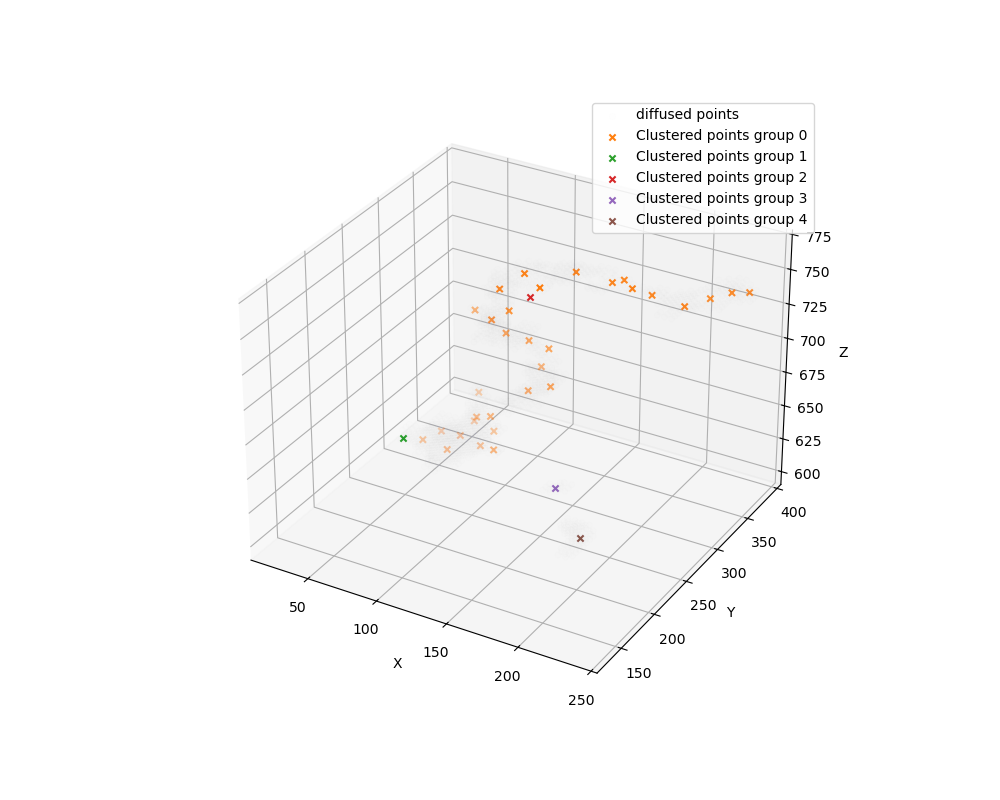

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(data['x'], data['y'], data['z'], marker='o',alpha=0.005, label = "diffused points")
# ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o',color="Teal")


for gid in sorted(databin.group_id.unique()):

    temp_df = databin[databin.group_id == gid]
    ax.scatter(temp_df['x'], temp_df['y'], temp_df['z'], marker='x', label = f"Clustered points group {gid}")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.legend()
plt.show()
# plt.savefig("plots/clustering/clustered_hits1.pdf")

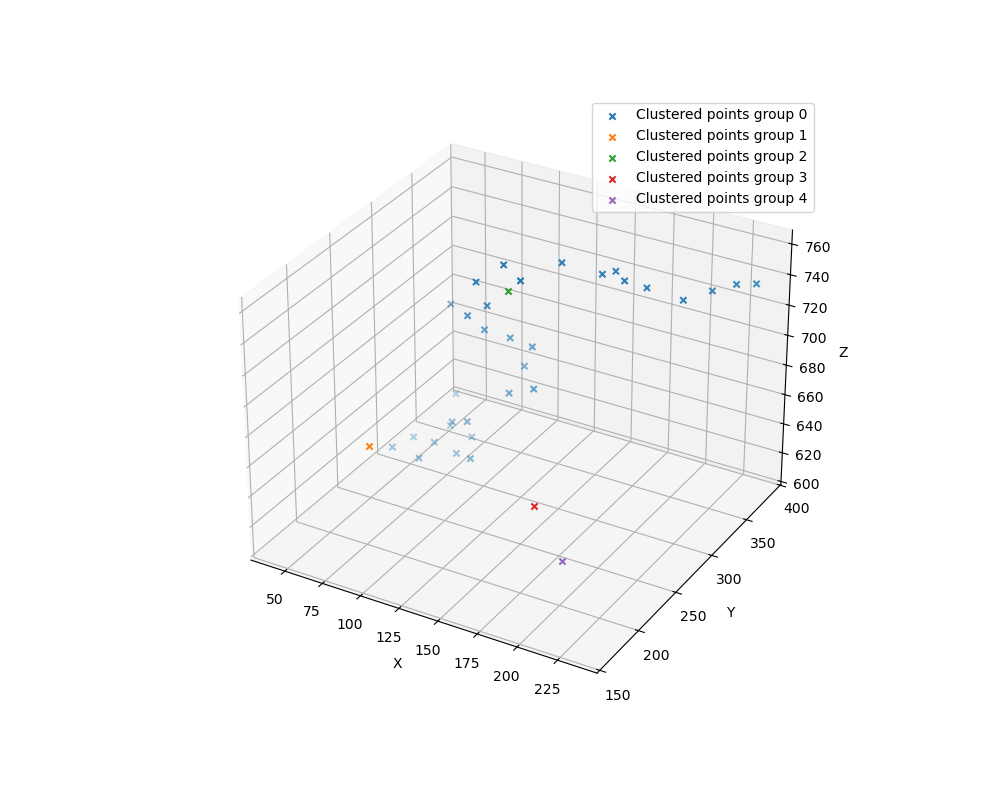

In [ ]:

# Plot the original points and the polynomial fit
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for gid in sorted(databin.group_id.unique()):

    temp_df = databin[databin.group_id == gid]
    ax.scatter(temp_df['x'], temp_df['y'], temp_df['z'], marker='x', label = f"Clustered points group {gid}")

# ax.scatter(databin.x, databin.y,databin.z, color='blue', label='Clustered Points', alpha=0.5)
# ax.scatter(data_true['x'], data_true['y'], data_true['z'],s=0.1 ,marker='o',color="Teal")

# Labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()
# plt.savefig("plots/clustering/clustered_hits2.pdf")

In [ ]:
display(databin)

# databin.to_hdf("../data/test/test.h5", "MC/hits")

print(databin.energy.sum())

,event_id,x_smear,y_smear,z_smear,x,y,z,energy,group_id
0,742575.0,37.5,287.5,612.5,41.403351,293.327899,610.175935,0.070014,0
1,742575.0,37.5,312.5,612.5,44.879866,314.061138,608.774167,0.071707,0
2,742575.0,62.5,287.5,612.5,61.921000,289.304323,610.604143,0.227200,0
3,742575.0,62.5,312.5,612.5,62.576437,307.684329,613.432328,0.126186,0
4,742575.0,62.5,337.5,612.5,62.337974,329.239701,615.194915,0.004263,0
5,742575.0,62.5,337.5,637.5,58.212083,344.645326,629.340274,0.011846,0
6,742575.0,62.5,337.5,687.5,62.393922,331.566166,698.069625,0.000384,0
7,742575.0,62.5,312.5,637.5,73.759395,310.137209,629.851741,0.025099,0
8,742575.0,87.5,312.5,637.5,87.705548,303.093776,637.502579,0.111140,0
9,742575.0,87.5,312.5,612.5,76.695729,309.680425,608.981957,0.023122,0


1.5292518493735168


Diffussion smear is:  0.1 mm/sqrt(cm)
Energy threshold is:  0.0 keV
diffision scale factor is:  7
Radius scale factor is:  10
Hit grouping factor is:  20
Tortuosity distance scale is: 15
The voxel size is: 5
The det half_length is:  1807.7267582900142
Median distance to the closest row: 17.396564318318184
Distances to iterate over [  1  13  25  38  50  62  75  87  99 112 124 136 149 161 173]
Dist Thresh 83.652
Pass Flag: True
The primary track is:  0
Brem distance failed distance threshold, try re-running to see if helps 23.833914254885006 < 27.884
Error in track reco, try resorting hits

Diffussion smear is:  0.1 mm/sqrt(cm)
Energy threshold is:  0.0 keV
diffision scale factor is:  7
Radius scale factor is:  10
Hit grouping factor is:  20
Tortuosity distance scale is: 15
The voxel size is: 5
The det half_length is:  1807.7267582900142
Median distance to the closest row: 17.396564318318184
Distances to iterate over [  1  13  25  38  50  62  75  87  99 112 124 136 149 161 173]
Dist Thre

,event_id,x,y,z,group_id,energy,id,primary,trkID,cumulative_distance,angle,Tortuosity,Squiglicity
id,,,,,,,,,,,,,
20,742575.0,62.393922,331.566166,698.069625,0,0.000384,20,1,0,0.000000,0.000000,1.000000,0.000000e+00
9,742575.0,58.212083,344.645326,629.340274,0,0.011846,9,1,0,70.087630,78.015697,1.000000,0.000000e+00
6,742575.0,62.337974,329.239701,615.194915,0,0.004263,6,1,0,91.405403,59.716253,1.000000,0.000000e+00
5,742575.0,78.892312,325.779183,613.685126,0,0.005486,5,1,0,108.384825,66.735096,1.000000,0.000000e+00
1,742575.0,76.695729,309.680425,608.981957,0,0.023122,1,1,0,125.299752,84.716327,1.000000,5.992026e-17
4,742575.0,62.576437,307.684329,613.432328,0,0.126186,4,1,0,140.237778,80.381689,1.000000,5.992026e-17
0,742575.0,44.879866,314.061138,608.774167,0,0.071707,0,1,0,159.616395,41.620120,1.000000,0.000000e+00
2,742575.0,41.403351,293.327899,610.175935,0,0.070014,2,1,0,180.685764,100.901771,1.000000,0.000000e+00
3,742575.0,61.921000,289.304323,610.604143,0,0.227200,3,1,0,201.598593,88.349362,1.000000,0.000000e+00


36 36


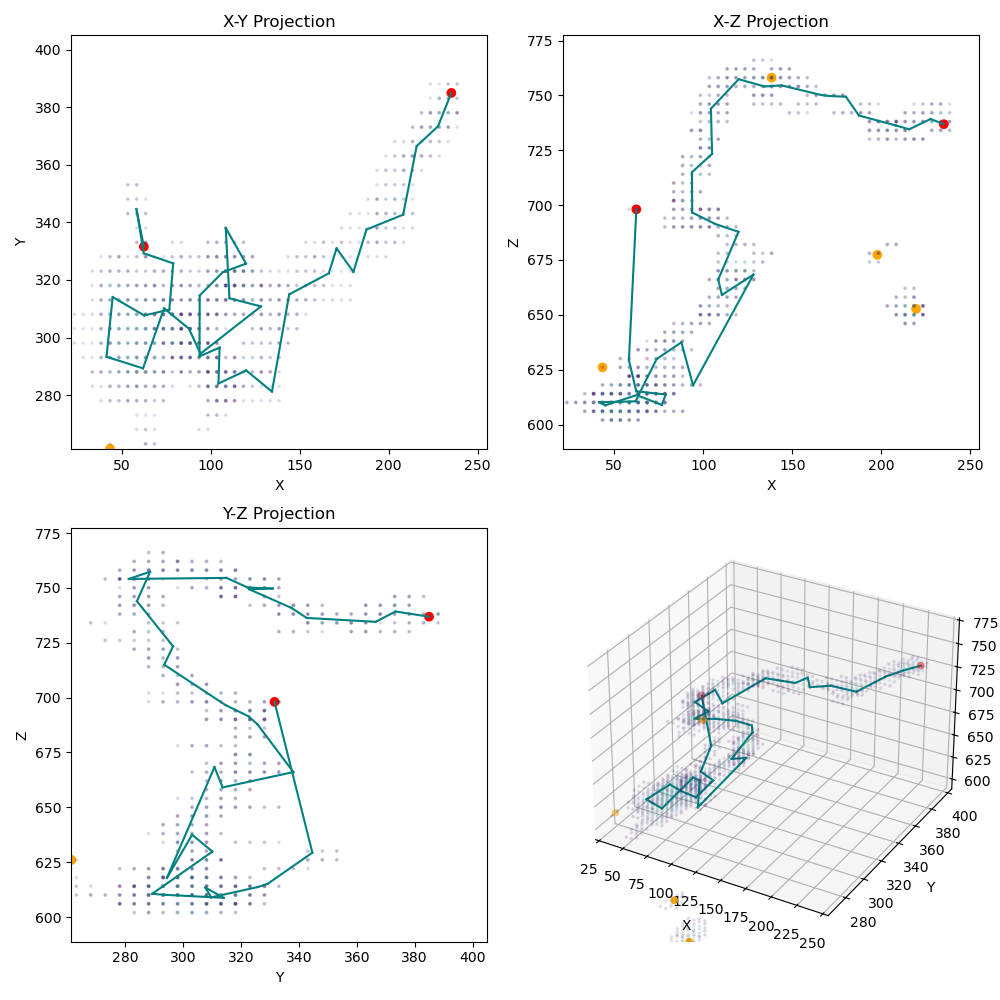

In [ ]:
# Apply the tracking reconstruction

# df, Tracks, connected_nodes, connection_count, pass_flag = RunTracking(databin[["event_id", "x", "y", "z", "energy"]], 0, 1, "5percent", 0)
df, Tracks, connected_nodes, connection_count, pass_flag, contained = RunTracking(databin, 0, pressure, diffusion, 0)
if (not pass_flag):
    print("Error in track reco, try resorting hits\n")
    df, Tracks, connected_nodes, connection_count, pass_flag, contained = RunTracking(databin, 0, pressure, diffusion, 1)
if (not pass_flag):
    print("Error in track reco, try resorting hits\n")
    df, Tracks, connected_nodes, connection_count, pass_flag, contained = RunTracking(databin, 0, pressure, diffusion, 2)

df.index = df.id

display(df)
print(len(df.x), len(df.z))

# Create subplots
fig = plt.figure(figsize=(10, 10))

axs = [fig.add_subplot(2, 2, i + 1) for i in range(3)]

# Plot xy projection
plot_tracks(axs[0], df['x'], df['y'], connection_count, 'X', 'Y', Tracks)
axs[0].scatter(data.x, data.y, c=colors, marker='o', alpha=0.1,s=3)
# axs[0].scatter(data_true['x'], data_true['y'], marker='o',c="k", s=0.1)

# Plot xz projection
plot_tracks(axs[1], df['x'], df['z'], connection_count, 'X', 'Z', Tracks)
axs[1].scatter(data.x, data.z, c=colors, marker='o', alpha=0.1,s=3)
# axs[1].scatter(data_true['x'], data_true['z'], marker='o',c="k", s=0.1)

# Plot yz projection
plot_tracks(axs[2], df['y'], df['z'], connection_count, 'Y', 'Z', Tracks)
axs[2].scatter(data.y, data.z, c=colors, marker='o', alpha=0.1,s=3)
# axs[2].scatter(data_true['y'], data_true['z'], marker='o',c="k", s=0.1)


# 3D Projection
ax_3D = fig.add_subplot(2, 2, 4, projection='3d')
plot_tracks_3D(ax_3D, df['x'], df['y'], df['z'], connection_count, Tracks)
# ax_3D.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o',c="k", s=0.1)
# ax_3D.scatter(data.x, data.y, data.z, c=colors, marker='o', alpha=0.5,s=3)
ax_3D.scatter(df_merged.x, df_merged.y, df_merged.z, c=df_merged.energy, marker='o', alpha=0.1,s=3)
ax_3D.set_title("")


# Get bounds of primary track 
df_prim = df[df.primary == 1]

lims = {
    "x": (df_prim.x.min()-20, df_prim.x.max()+20),
    "y": (df_prim.y.min()-20, df_prim.y.max()+20),
    "z": (df_prim.z.min()-20, df_prim.z.max()+20)
}

axs[0].set_xlim(*lims["x"])
axs[0].set_ylim(*lims["y"])
axs[1].set_xlim(*lims["x"])
axs[1].set_ylim(*lims["z"])
axs[2].set_xlim(*lims["y"])
axs[2].set_ylim(*lims["z"])
ax_3D.set_xlim(*lims["x"])
ax_3D.set_ylim(*lims["y"])
ax_3D.set_zlim(*lims["z"])

plt.tight_layout()
plt.show()

In [ ]:
if (diffusion == "next1t"):
    temp_meta = GetTrackdf(df, Tracks, 30, 15, 15, pressure)
else:
    temp_meta = GetTrackdf(df, Tracks, 500/pressure, 180/pressure, 200/pressure, pressure) # scale these params inversely with the pressure

display(temp_meta)
# temp_meta = UpdateTrackMeta(temp_meta, df, 100/pressure) # Merge deltas and brems that are near the blobs in the metadata
temp_meta = UpdateTrackMeta2(temp_meta)
temp_meta["contained"] = contained
display(temp_meta)

,event_id,trkID,primary,start,end,length,energy,blob1,blob2,blob1R,blob2R,blob1RTD,blob2RTD,Tortuosity1,Tortuosity2,Squiglicity1,Squiglicity2,label
0,742575.0,0,1,20,25,717.502,1.409492,0.016493,0.159459,0.059346,0.088954,0.059346,0.088954,1.0,1.020541,0.0,0.079177,Primary
0,742575.0,1,0,8,8,0.000,0.000367,0.000367,0.000367,0.000367,0.000367,0.000000,0.000000,0.0,0.000000,0.0,0.000000,Brem
0,742575.0,2,0,12,12,0.000,0.101717,0.101717,0.101717,0.101717,0.101717,0.000000,0.000000,0.0,0.000000,0.0,0.000000,Brem
0,742575.0,3,0,16,16,0.000,0.017456,0.017456,0.017456,0.017456,0.017456,0.000000,0.000000,0.0,0.000000,0.0,0.000000,Brem
0,742575.0,4,0,35,35,0.000,0.000220,0.000220,0.000220,0.000220,0.000220,0.000000,0.000000,0.0,0.000000,0.0,0.000000,Brem


,event_id,trkID,primary,start,end,length,energy,blob1,blob2,blob1R,blob2R,blob1RTD,blob2RTD,Tortuosity1,Tortuosity2,Squiglicity1,Squiglicity2,label,contained
0,742575.0,0,1,20,25,717.502,1.409492,0.159459,0.016493,0.088954,0.059346,0.088954,0.059346,1.020541,1.0,0.079177,0.0,Primary,True
0,742575.0,1,0,8,8,0.000,0.000367,0.000367,0.000367,0.000367,0.000367,0.000000,0.000000,0.000000,0.0,0.000000,0.0,Brem,True
0,742575.0,2,0,12,12,0.000,0.101717,0.101717,0.101717,0.101717,0.101717,0.000000,0.000000,0.000000,0.0,0.000000,0.0,Brem,True
0,742575.0,3,0,16,16,0.000,0.017456,0.017456,0.017456,0.017456,0.017456,0.000000,0.000000,0.000000,0.0,0.000000,0.0,Brem,True
0,742575.0,4,0,35,35,0.000,0.000220,0.000220,0.000220,0.000220,0.000220,0.000000,0.000000,0.000000,0.0,0.000000,0.0,Brem,True


Text(0, 0.5, 'Angle')

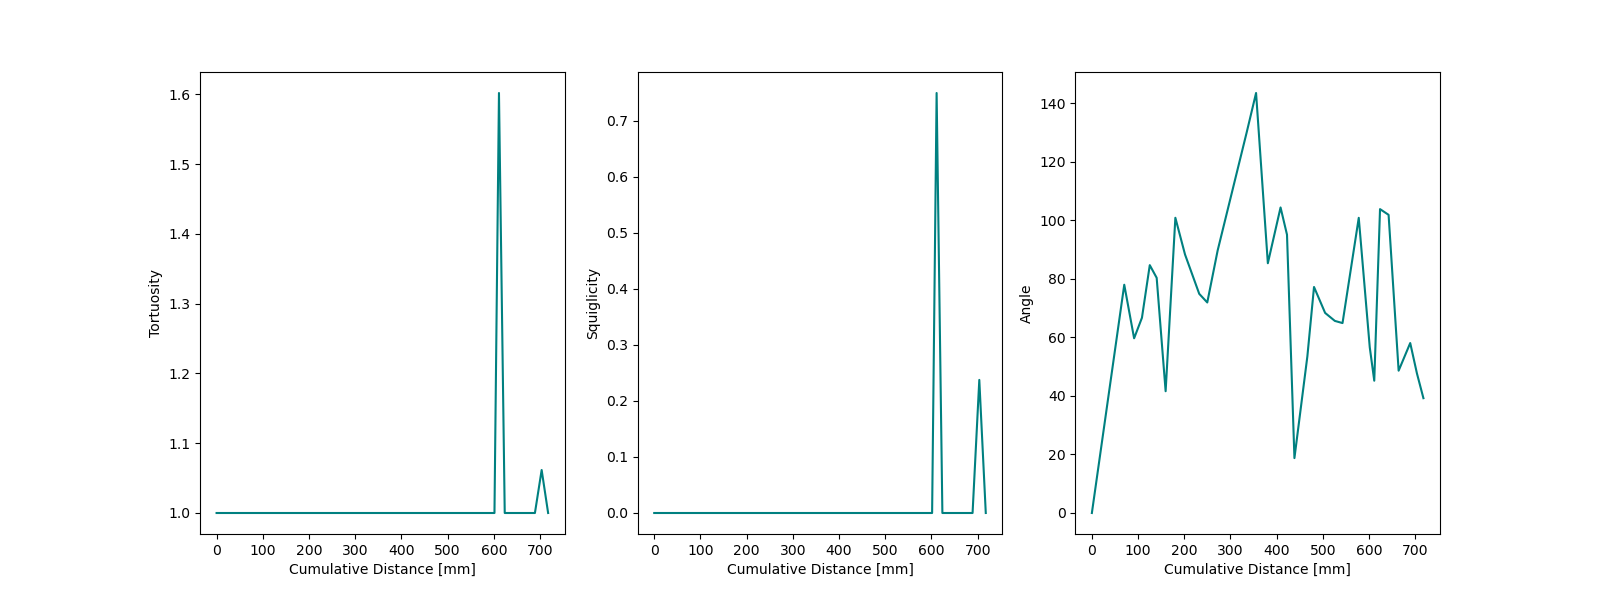

In [ ]:

fig, axs = plt.subplots(1, 3, figsize=(16, 6))

axs[0].plot(df[df.primary == 1].cumulative_distance, df[df.primary == 1]["Tortuosity"], c="Teal")
axs[0].set_xlabel("Cumulative Distance [mm]")
axs[0].set_ylabel("Tortuosity")

axs[1].plot(df[df.primary == 1].cumulative_distance, df[df.primary == 1]["Squiglicity"], c="Teal")
axs[1].set_xlabel("Cumulative Distance [mm]")
axs[1].set_ylabel("Squiglicity")


axs[2].plot(df[df.primary == 1].cumulative_distance, df[df.primary == 1]["angle"], c="Teal")
axs[2].set_xlabel("Cumulative Distance [mm]")
axs[2].set_ylabel("Angle")

,Unnamed: 0,Energies
0,0,1.653323
1,1,1.756935
2,2,1.641893
3,3,1.591002
4,4,1.447637
...,...,...
24701,24701,1.597513
24702,24702,1.731423
24703,24703,1.460908
24704,24704,1.637865


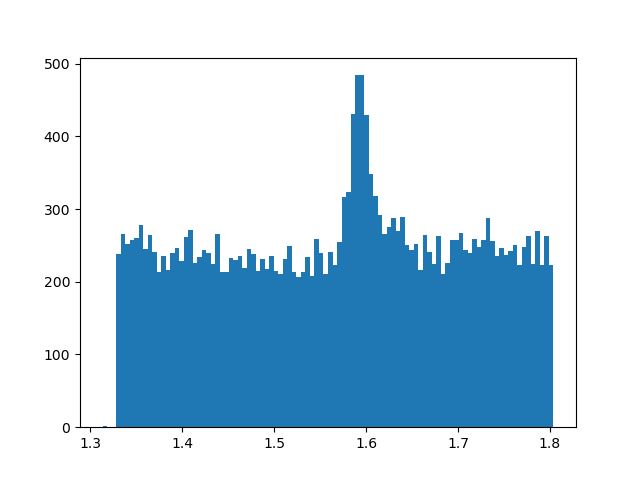

In [ ]:
# Plot the energy distribution

event_energies = pd.read_csv("../../data/NEXT100/354015.csv")
display(event_energies)

plt.figure()

plt.hist(event_energies.Energies, bins = 100);